## Defining the data path


In [12]:
date = "10.25"
# date = "10.02"

data_dir = f"processed_data_{date}"
csv_mc = f"model_conversion_{date}.csv"
csv_dp = f"data_processing_{date}.csv"
csv_sg = f"sketch_generation_{date}.csv"

## Printing statistics


In [13]:
import pandas as pd
import numpy as np

# data_dir = "processed_data"

input_csv = csv_mc
# # Assuming df is your input DataFrame
# df = pd.read_csv(f"{input_csv}")
df = pd.read_csv(f"{data_dir}/{input_csv}")


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
        "median": df[column].median(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


# Calculate statistics for each specified column
stats = {
    "total_tokens": calculate_stats(df, "total_tokens"),
    "input_tokens": calculate_stats(df, "input_tokens"),
    "output_tokens": calculate_stats(df, "output_tokens"),
    "latency": calculate_stats(df, "latency"),
    "total_cost": calculate_stats(df, "total_cost"),
    "input_cost": calculate_stats(df, "input_cost"),
    "output_cost": calculate_stats(df, "output_cost"),
}

# Calculate success rate
success_rate = (df["pass"] == "yes").mean() * 100

# Print results
print(f"Task: {input_csv}")
for metric, values in stats.items():
    print(f"{metric}:")
    for stat, value in values.items():
        print(f"    {stat}: {value:.4f}")
    print()

print(f"Success rate: {success_rate:.2f}%")

Task: model_conversion_10.25.csv
total_tokens:
    average: 793.0000
    minimum: 534.0000
    maximum: 4035.0000
    median: 567.0000

input_tokens:
    average: 508.0000
    minimum: 299.0000
    maximum: 3463.0000
    median: 299.0000

output_tokens:
    average: 284.0000
    minimum: 235.0000
    maximum: 572.0000
    median: 268.0000

latency:
    average: 8.8738
    minimum: 6.6633
    maximum: 22.0803
    median: 7.9785

total_cost:
    average: 0.0068
    minimum: 0.0050
    maximum: 0.0259
    median: 0.0055

input_cost:
    average: 0.0025
    minimum: 0.0015
    maximum: 0.0173
    median: 0.0015

output_cost:
    average: 0.0043
    minimum: 0.0035
    maximum: 0.0086
    median: 0.0040

Success rate: 100.00%


## Print in a table: total_tokens and latency

In [14]:
def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        # Handle NaN values by replacing them with 0 before converting to int
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def print_stats_table(df, task_name):
    # Calculate stats
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "yes")
    failed_stats = calculate_stats_by_status(df, "no")
    success_rate = (df["pass"] == "yes").mean() * 100

    print(f"\n=== {task_name} ===")
    print(
        "{:<15} {:<15} {:<12} {:<12} {:<12}".format(
            "Status", "Metric", "Average", "Minimum", "Maximum"
        )
    )
    print("-" * 66)

    # Create rows for latency
    for status, stats in [
        ("Overall", overall_stats),
        ("Passed", passed_stats),
        ("Failed", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "latency",
                stats["latency"]["average"],
                stats["latency"]["minimum"],
                stats["latency"]["maximum"],
            )
        )

    # Print blank line between metrics
    print()

    # Create rows for total_tokens
    for status, stats in [
        ("Overall", overall_stats),
        ("Passed", passed_stats),
        ("Failed", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "total_tokens",
                stats["total_tokens"]["average"],
                stats["total_tokens"]["minimum"],
                stats["total_tokens"]["maximum"],
            )
        )

    print(f"\nSuccess rate: {success_rate:.2f}%")


# Load all datasets
df_sketch_generator = pd.read_csv(f"{data_dir}/{csv_sg}")
df_data_processing = pd.read_csv(f"{data_dir}/{csv_dp}")
df_model_convert = pd.read_csv(f"{data_dir}/{csv_mc}")

# Print stats for each dataset
print_stats_table(df_sketch_generator, "Sketch Generator")
print_stats_table(df_data_processing, "Data Processing")
print_stats_table(df_model_convert, "Model Convert")


=== Sketch Generator ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         117.86       7.13         242.87      
Passed          latency         113.86       7.13         242.87      
Failed          latency         119.58       74.91        174.24      

Overall         total_tokens    13028.00     1731.00      16602.00    
Passed          total_tokens    10094.00     1731.00      14222.00    
Failed          total_tokens    14286.00     11741.00     16602.00    

Success rate: 30.00%

=== Data Processing ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         44.17        31.68        73.88       
Passed          latency         44.17        31.68        73.88       
Failed          latency         nan          nan          nan         

Overall   

## Plotting bar chart

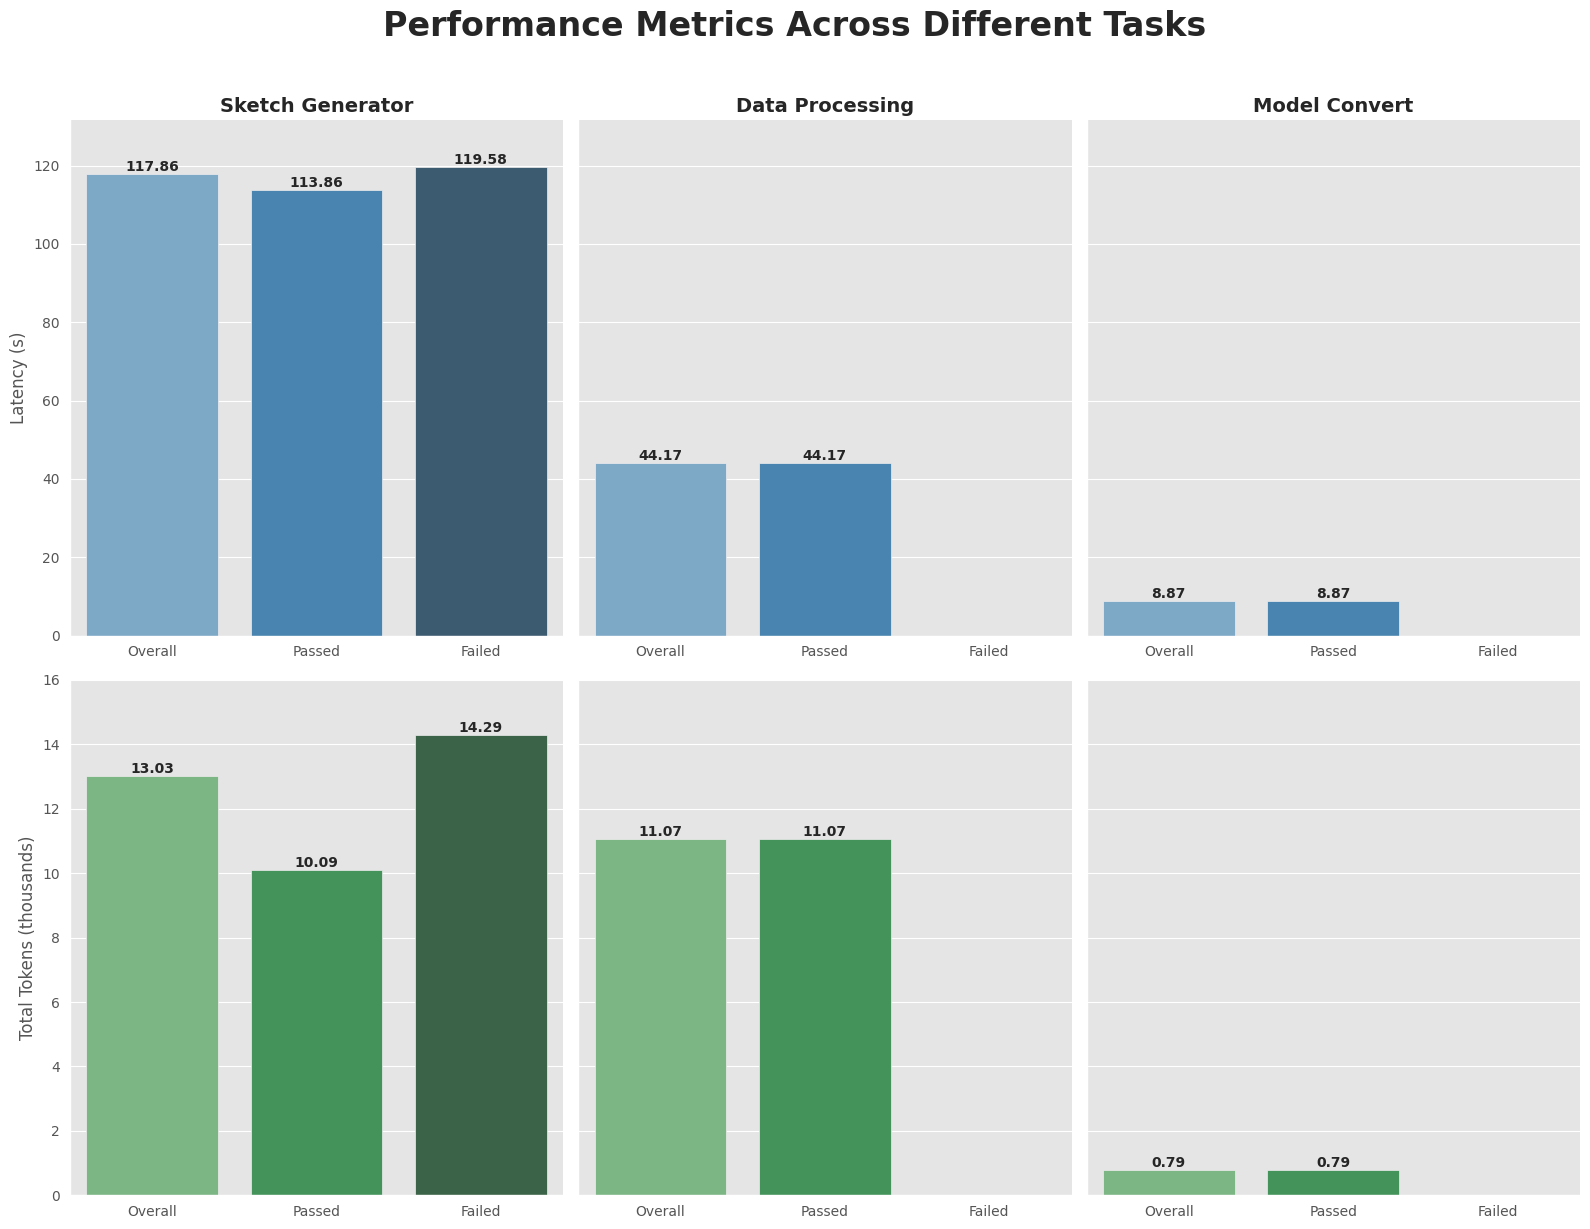

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load all datasets
df_sketch_generator = pd.read_csv(f"{data_dir}/{csv_sg}")
df_data_processing = pd.read_csv(f"{data_dir}/{csv_dp}")
df_model_convert = pd.read_csv(f"{data_dir}/{csv_mc}")

# Font size configurations
TITLE_FONT_SIZE = 24
SUBTITLE_FONT_SIZE = 14
LABEL_FONT_SIZE = 10
ANNOTATION_FONT_SIZE = 10


def calculate_stats(df, column):
    return {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["pass"] == status]
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(df, "yes")
    failed_stats = calculate_stats_by_status(df, "no")

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed", passed_stats),
            ("Failed", failed_stats),
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


# Prepare data for plotting
df_sketch = prepare_data_for_plot(df_sketch_generator, "Sketch Generator")
df_data = prepare_data_for_plot(df_data_processing, "Data Processing")
df_model = prepare_data_for_plot(df_model_convert, "Model Convert")

# Combine all data
df_all = pd.concat([df_sketch, df_data, df_model])

# Determine global y-axis limits
latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

# ... (keep the data loading and preparation code unchanged)

# Set the style
plt.style.use("ggplot")
sns.set_palette("muted")

# Plotting
tasks = df_all["Task"].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12), sharey="row")

for col, task in enumerate(tasks):
    task_data = df_all[df_all["Task"] == task]

    # Plot latency
    ax_latency = axes[0, col]
    latency_data = task_data[task_data["Metric"] == "latency"]
    sns.barplot(
        x="Status",
        y="Average",
        data=latency_data,
        ax=ax_latency,
        hue="Status",
        palette="Blues_d",
        legend=False,
    )
    ax_latency.set_ylabel("Latency (s)" if col == 0 else "")
    ax_latency.set_ylim(0, latency_max * 1.1)
    ax_latency.set_title(task, fontsize=SUBTITLE_FONT_SIZE, fontweight="bold")

    # Annotate latency bars
    for i, bar in enumerate(ax_latency.patches):
        yval = bar.get_height()
        ax_latency.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=ANNOTATION_FONT_SIZE,
        )

    # Plot total tokens
    ax_tokens = axes[1, col]
    tokens_data = task_data[task_data["Metric"] == "total_tokens"]
    sns.barplot(
        x="Status",
        y="Average",
        data=tokens_data,
        ax=ax_tokens,
        hue="Status",
        palette="Greens_d",
        legend=False,
    )
    ax_tokens.set_ylabel("Total Tokens (thousands)" if col == 0 else "")
    ax_tokens.set_ylim(0, tokens_max * 1.1)

    # Set y-axis ticks manually
    y_ticks = ax_tokens.get_yticks()
    ax_tokens.set_yticks(y_ticks)
    ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in y_ticks])

    # Annotate token bars
    for i, bar in enumerate(ax_tokens.patches):
        yval = bar.get_height()
        ax_tokens.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval/1000:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=ANNOTATION_FONT_SIZE,
        )

    # Improve readability
    for ax in [ax_latency, ax_tokens]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=LABEL_FONT_SIZE)
        ax.set_xlabel("")

# Add overall title
fig.suptitle(
    "Performance Metrics Across Different Tasks",
    fontsize=TITLE_FONT_SIZE,
    fontweight="bold",
    y=1.02,
)

# Adjust layout
plt.tight_layout()
plt.savefig(f"bar_plot_{date}.pdf", format="pdf", dpi=400)
plt.show()

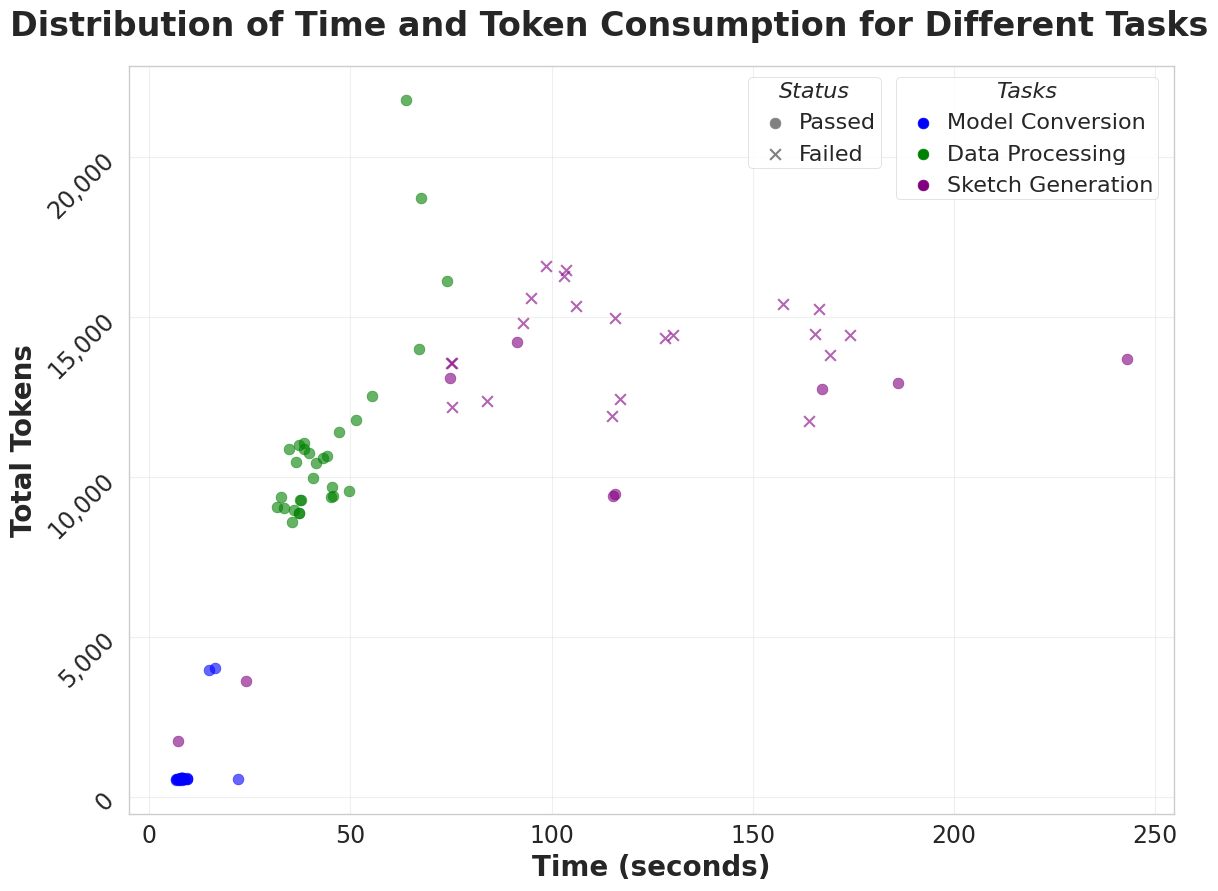

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 24
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Load the data from CSV files
df_sketch_generator = pd.read_csv(f"{data_dir}/{csv_sg}")
df_data_processing = pd.read_csv(f"{data_dir}/{csv_dp}")
df_model_convert = pd.read_csv(f"{data_dir}/{csv_mc}")

# Combine all dataframes into a single dataframe with an additional 'task' column
df_sketch_generator["task"] = "Sketch Generation"
df_data_processing["task"] = "Data Processing"
df_model_convert["task"] = "Model Conversion"

df_combined = pd.concat([df_sketch_generator, df_data_processing, df_model_convert])

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors and markers for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

task_markers = {
    "yes": "o",  # Circle for successful runs
    "no": "x",  # Cross for failed runs
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    task_data = df_combined[df_combined["task"] == task]

    # Plot passed runs
    passed = task_data[task_data["pass"] == "yes"]
    plt.scatter(
        passed["latency"],
        passed["total_tokens"],
        color=color,
        alpha=0.6,
        label=task,  # Label only with task name
        marker="o",  # Circle for passed
        s=60,
    )

    # Plot failed runs without labels (to avoid task repetition in legend)
    failed = task_data[task_data["pass"] == "no"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",  # X for failed
        s=60,
    )

# Set labels and title
plt.xlabel("Time (seconds)", fontsize=label_fontsize, fontweight=label_fontweight)
plt.ylabel("Total Tokens", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Distribution of Time and Token Consumption for Different Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.03,
    fontweight=title_fontweight,
)
plt.tick_params(
    axis="both",
    which="major",
    labelsize=17,
)

# Format the y-axis numbers with commas
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))

# Format the x-axis numbers with commas if needed
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
# Add separate pass/fail markers to legend
plt.scatter([], [], color="gray", marker="o", label="Passed", s=60)
plt.scatter([], [], color="gray", marker="x", label="Failed", s=60)

# Add legend
plt.yticks(rotation=45, ha="right", fontweight=tick_fontweight)
plt.xticks(fontweight=tick_fontweight)
# ... existing code until the legend section ...

# ... existing code remains the same until legend section ...

# Create two separate legend handles and labels
task_handles = []
task_labels = []
status_handles = []
status_labels = []

# Collect task handles and labels
for task, color in task_colors.items():
    task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
    task_labels.append(task)

# Add status handles and labels
status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
status_labels.extend(["Passed", "Failed"])

legend_title_prop = {
    "weight": legend_fontweight,
    "size": legend_fontsize,
    "style": "italic",
}


# Create legend with two handle/label sets side by side
first_legend = plt.legend(
    task_handles,
    task_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 1.0),  # Position for first legend
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Tasks",
    title_fontproperties=legend_title_prop,
)

# Add the second legend for status markers
plt.gca().add_artist(first_legend)
plt.legend(
    status_handles,
    status_labels,
    loc="upper right",
    bbox_to_anchor=(
        0.73,
        1.0,
    ),  # Position for second legend - adjust this value to control horizontal spacing
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Status",
    title_fontproperties=legend_title_prop,
)

# ... rest of the code remains the same ...

# Add grid and show plot
plt.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()
plt.savefig(
    f"scatter_plot_{date}.pdf", format="pdf", dpi=400
)  # Removed bbox_inches='tight' as it's no longer needed
plt.show()